In [22]:
import torch, pickle, logging, importlib, os
import util.imu_model, util.train_utils, util.data_utils
import matplotlib.pyplot as plt
import numpy as np

importlib.reload(util.imu_model)
importlib.reload(util.train_utils)
importlib.reload(util.data_utils)

from util.imu_model import IMU_LSTM_Model
from util.train_utils import train_model_cv
from util.data_utils import CMI_Dataset, good_labels, bad_labels
from pathlib import Path


logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    handlers=[
        logging.FileHandler("training_output.log"),
        logging.StreamHandler()
    ]
)
logging.getLogger().setLevel(logging.INFO)

current_dir = os.getcwd()
print(current_dir)

/home/ziran_unix/projects/Kaggle/CMI


# Load Processed Dataset

In [4]:
with open("data/processed/train_dataset_v1.pkl", "rb") as f:
    train_dataset = pickle.load(f)

with open("data/processed/test_dataset_v1.pkl", "rb") as f:
    test_dataset = pickle.load(f)

# IMU Only LSTM Model (baseline)

In [12]:
model_params = {
    "num_classes": 18,
    "input_dim_demo": 7,
    "input_dim_imu": 7,
    "hidden_dim": 32,
    "num_layers": 1
}

train_history = train_model_cv(
    IMU_LSTM_Model,
    train_dataset,
    model_kwargs=model_params,
    num_epochs=100,
    k_folds=4,
    batch_size=32,
    lr=1e-3,
    weight_decay=1e-4,
    eval_every=1,
    early_stopping_patience=10,
    early_stopping_delta=2e-2
)

2025-06-21 17:29:56,198 | INFO | util.train_utils | Fold 1/4 | Training...
2025-06-21 17:29:59,618 | INFO | util.train_utils | Fold 1/4 | Epoch 01 | Train Loss: 2.6541 | Val Loss: 2.4068
2025-06-21 17:30:02,798 | INFO | util.train_utils | Fold 1/4 | Epoch 02 | Train Loss: 2.3312 | Val Loss: 2.2433
2025-06-21 17:30:05,974 | INFO | util.train_utils | Fold 1/4 | Epoch 03 | Train Loss: 2.2311 | Val Loss: 2.1757
2025-06-21 17:30:09,136 | INFO | util.train_utils | Fold 1/4 | Epoch 04 | Train Loss: 2.1613 | Val Loss: 2.1128
2025-06-21 17:30:12,295 | INFO | util.train_utils | Fold 1/4 | Epoch 05 | Train Loss: 2.0981 | Val Loss: 2.0578
2025-06-21 17:30:15,497 | INFO | util.train_utils | Fold 1/4 | Epoch 06 | Train Loss: 2.0725 | Val Loss: 2.0205
2025-06-21 17:30:18,035 | INFO | util.train_utils | Fold 1/4 | Epoch 07 | Train Loss: 2.0360 | Val Loss: 2.0280
2025-06-21 17:30:19,448 | INFO | util.train_utils | Fold 1/4 | Epoch 08 | Train Loss: 1.9904 | Val Loss: 1.9707
2025-06-21 17:30:21,312 | INF

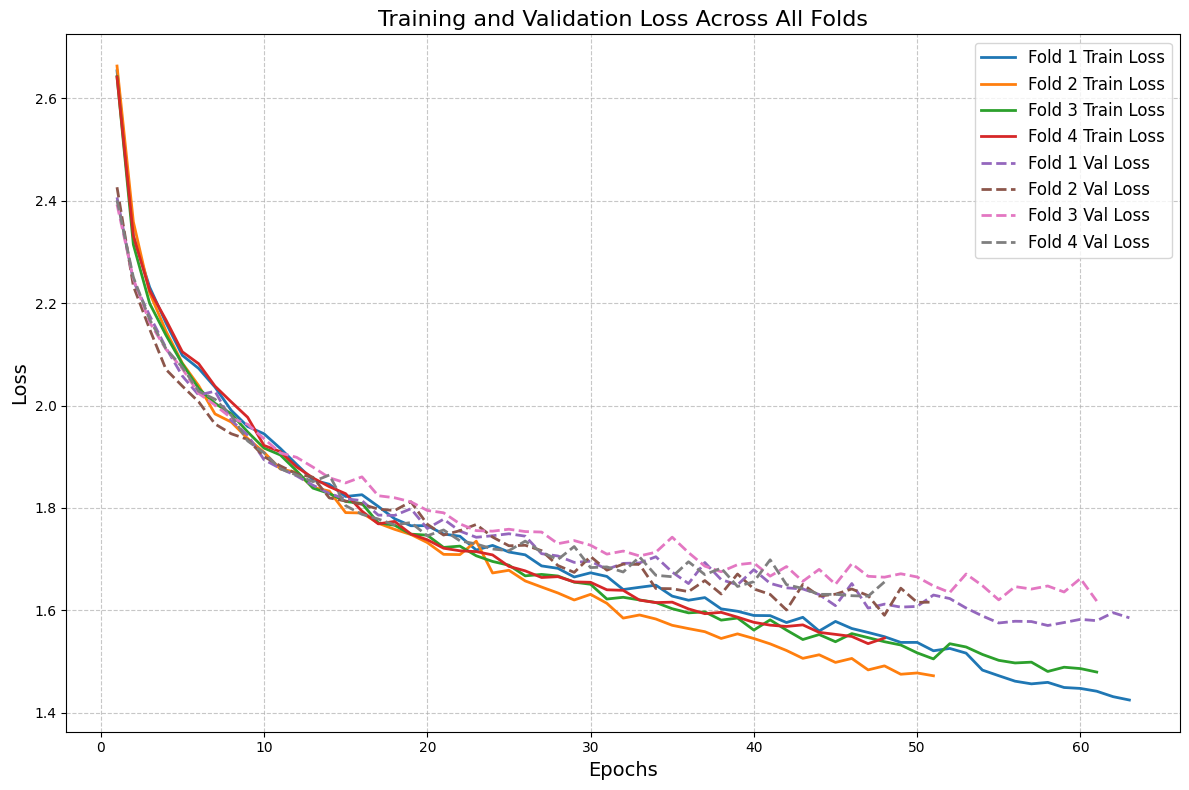

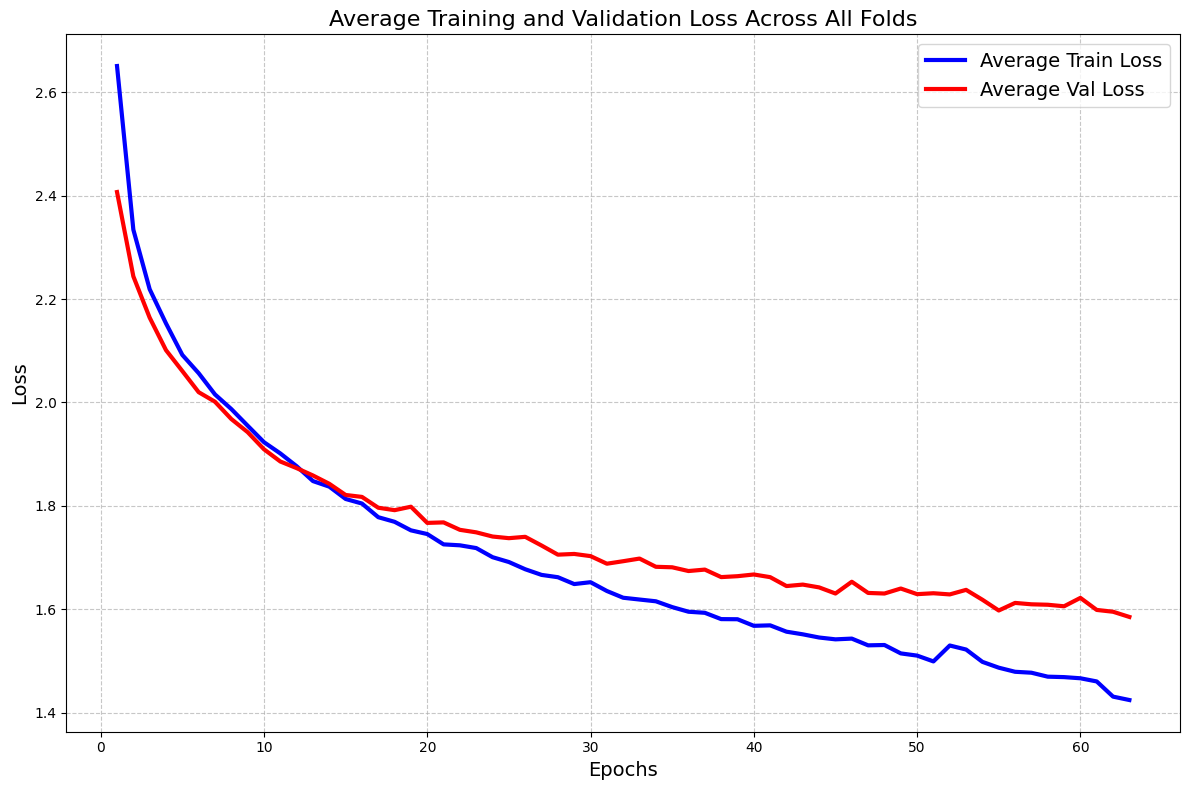

In [15]:
plt.figure(figsize=(12, 8))

# Plot training loss for all folds
for i, fold in enumerate(train_history):
    train_loss = fold['train_loss']
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, '-', linewidth=2, label=f'Fold {i+1} Train Loss')

# Plot validation loss for all folds
for i, fold in enumerate(train_history):
    val_loss = fold['val_loss']
    epochs = range(1, len(val_loss) + 1)
    plt.plot(epochs, val_loss, '--', linewidth=2, label=f'Fold {i+1} Val Loss')

plt.title('Training and Validation Loss Across All Folds', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Calculate and display average loss across folds
max_epochs = max([len(fold['train_loss']) for fold in train_history])
avg_train_loss = np.zeros(max_epochs)
avg_val_loss = np.zeros(max_epochs)
counts_train = np.zeros(max_epochs)
counts_val = np.zeros(max_epochs)

for fold in train_history:
    for i, loss in enumerate(fold['train_loss']):
        avg_train_loss[i] += loss
        counts_train[i] += 1
    for i, loss in enumerate(fold['val_loss']):
        avg_val_loss[i] += loss
        counts_val[i] += 1

# Compute averages
for i in range(max_epochs):
    if counts_train[i] > 0:
        avg_train_loss[i] /= counts_train[i]
    if counts_val[i] > 0:
        avg_val_loss[i] /= counts_val[i]

# Plot average losses
plt.figure(figsize=(12, 8))
plt.plot(range(1, max_epochs + 1), avg_train_loss, 'b-', linewidth=3, label='Average Train Loss')
plt.plot(range(1, max_epochs + 1), avg_val_loss, 'r-', linewidth=3, label='Average Val Loss')
plt.title('Average Training and Validation Loss Across All Folds', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


# Model Evaluation

In [2]:
with open("data/processed/train_dataset_v1.pkl", "rb") as f:
    train_dataset = pickle.load(f)

with open("data/processed/test_dataset_v1.pkl", "rb") as f:
    test_dataset = pickle.load(f)

with open("results/imu_lstm_training_history.pkl", "rb") as f:
    train_history = pickle.load(f)

train_history[0]['best_model']

'/home/ziran_unix/projects/Kaggle/CMI/results/weights/imu_lstm_weights_fold_1.pth'

In [3]:
labels, preds = [], []
for fold in train_history:
    model_weights = fold['best_model'] if not isinstance(fold['best_model'], str) else torch.load(fold['best_model'])
    test_model = IMU_LSTM_Model(**fold['model_params'])
    test_model.load_state_dict(model_weights)

    pred_idx = fold['val_idx']
    fold_labels,  fold_preds = test_model.predict(train_dataset, pred_idx)
    labels.append(fold_labels)
    preds.append(fold_preds)

labels = torch.cat(labels, dim=0)
preds = torch.cat(preds, dim=0)

print(f"low level accuracy: {(labels==preds).float().mean()}")

low level accuracy: 0.3771316409111023


In [4]:
mapping_tensor = torch.tensor([0 if i in good_labels else 1 for i in range(18)])
mapped_labels = mapping_tensor[labels]
mapped_preds = mapping_tensor[preds]

print(f"low level accuracy: {(mapped_labels==mapped_preds).float().mean()}")

low level accuracy: 0.9321555495262146


In [30]:
for i, fold in enumerate(train_history):
    filepath = Path(current_dir) / "results" / "weights" / f"imu_lstm_weights_fold_{i+1}.pth"
    model_weights = fold['best_model']
    torch.save(model_weights, filepath)
    fold['best_model'] = filepath.as_posix()

with open("results/imu_lstm_training_history.pkl", "wb") as f:
    pickle.dump(train_history, f)

In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset, 
    batch_size=32,
    shuffle=True, 
    collate_fn=train_dataset.collate_fn
)

for batch in train_loader:
    # print(batch)
    break

In [9]:
print(f"mask shape: {batch['mask'].shape}")
print(f"labels shape: {batch['labels'].shape}")
print(f"labels2 shape: {batch['labels2'].shape}")
print(f"demo shape: {batch['demo'].shape}")
print(f"seq_imu shape: {batch['seq_imu'].shape}")
print(f"seq_1d shape: {batch['seq_1d'].shape}")
print(f"seq_2d_tof shape: {batch['seq_2d_tof'].shape}")
print(f"seq_2d_itof shape: {batch['seq_2d_itof'].shape}")

mask shape: torch.Size([32, 199])
labels shape: torch.Size([32])
labels2 shape: torch.Size([32])
demo shape: torch.Size([32, 7])
seq_imu shape: torch.Size([32, 199, 7])
seq_1d shape: torch.Size([32, 199, 12])
seq_2d_tof shape: torch.Size([32, 199, 5, 8, 8])
seq_2d_itof shape: torch.Size([32, 199, 5, 8, 8])


In [10]:
batch['mask']

tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]])

# TOF Model

In [25]:
import util.tof_model, util.train_utils, importlib
import torch.optim as optim

importlib.reload(util.train_utils)
from util.train_utils import train_model_cv

importlib.reload(util.tof_model)
from util.tof_model import TOF_Model

tof_params = {
    "num_classes": 18,
    "input_dim_demo": 7,
    "input_dim_1d": 12,
    "hidden_dim": 32,
    "num_lstm_layers": 1,
    "num_2d_features": 16,
    "dropout_rate": 0.2,
    "pooling_type": "avg"
}

tof_training_history = train_model_cv(
    TOF_Model,
    train_dataset,
    model_kwargs=tof_params,
    num_epochs=100,
    k_folds=4,
    batch_size=32,
    lr=1e-3,
    weight_decay=1e-4,
    eval_every=1,
    early_stopping_patience=10,
    early_stopping_delta=2e-2,
    scheduler_fn=lambda opt: optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)
)

2025-06-22 17:21:46,148 | INFO | util.train_utils | Fold 1/4 | Training...
2025-06-22 17:21:50,124 | INFO | util.train_utils | Fold 1/4 | Epoch 01 | Train Loss: 2.3292 | Val Loss: 1.8891
2025-06-22 17:21:53,600 | INFO | util.train_utils | Fold 1/4 | Epoch 02 | Train Loss: 1.8772 | Val Loss: 1.6558
2025-06-22 17:21:57,130 | INFO | util.train_utils | Fold 1/4 | Epoch 03 | Train Loss: 1.7216 | Val Loss: 1.5867
2025-06-22 17:22:00,659 | INFO | util.train_utils | Fold 1/4 | Epoch 04 | Train Loss: 1.6308 | Val Loss: 1.5155
2025-06-22 17:22:04,156 | INFO | util.train_utils | Fold 1/4 | Epoch 05 | Train Loss: 1.5539 | Val Loss: 1.4296
2025-06-22 17:22:07,719 | INFO | util.train_utils | Fold 1/4 | Epoch 06 | Train Loss: 1.5091 | Val Loss: 1.4336
2025-06-22 17:22:12,866 | INFO | util.train_utils | Fold 1/4 | Epoch 07 | Train Loss: 1.4759 | Val Loss: 1.3774
2025-06-22 17:22:16,519 | INFO | util.train_utils | Fold 1/4 | Epoch 08 | Train Loss: 1.4350 | Val Loss: 1.3556
2025-06-22 17:22:19,978 | INF

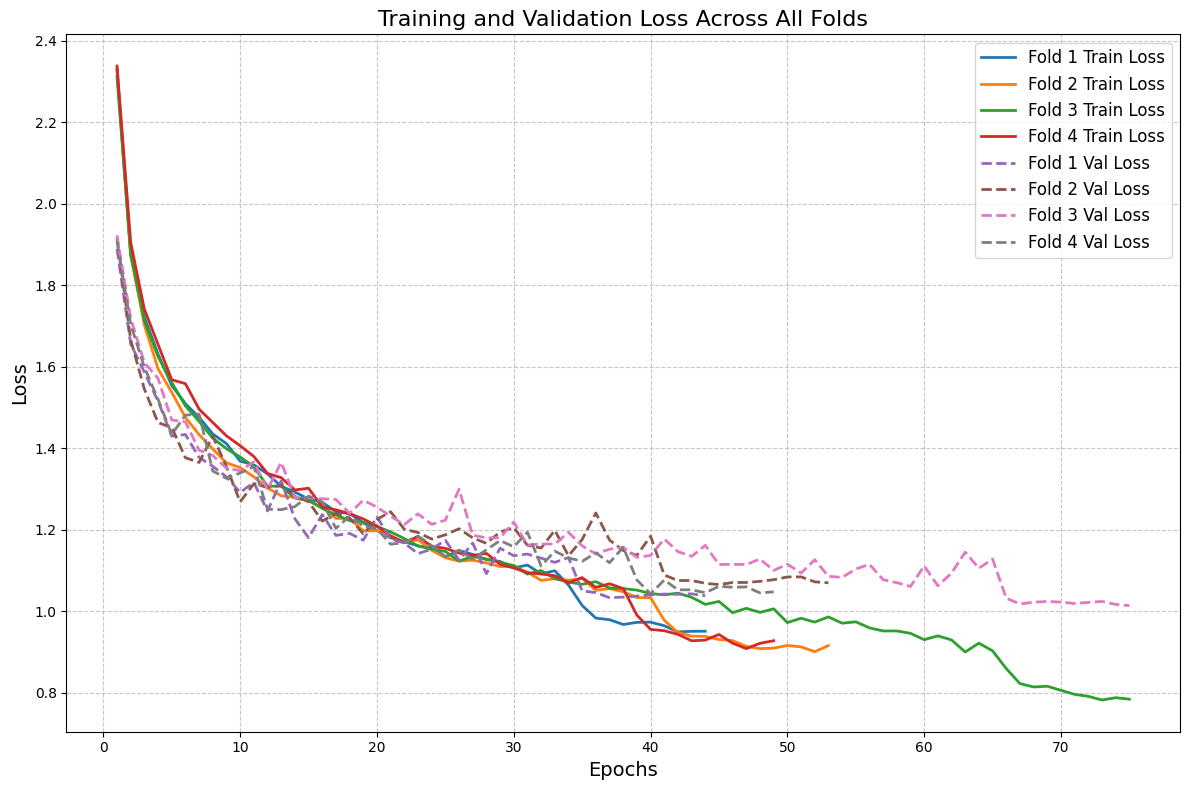

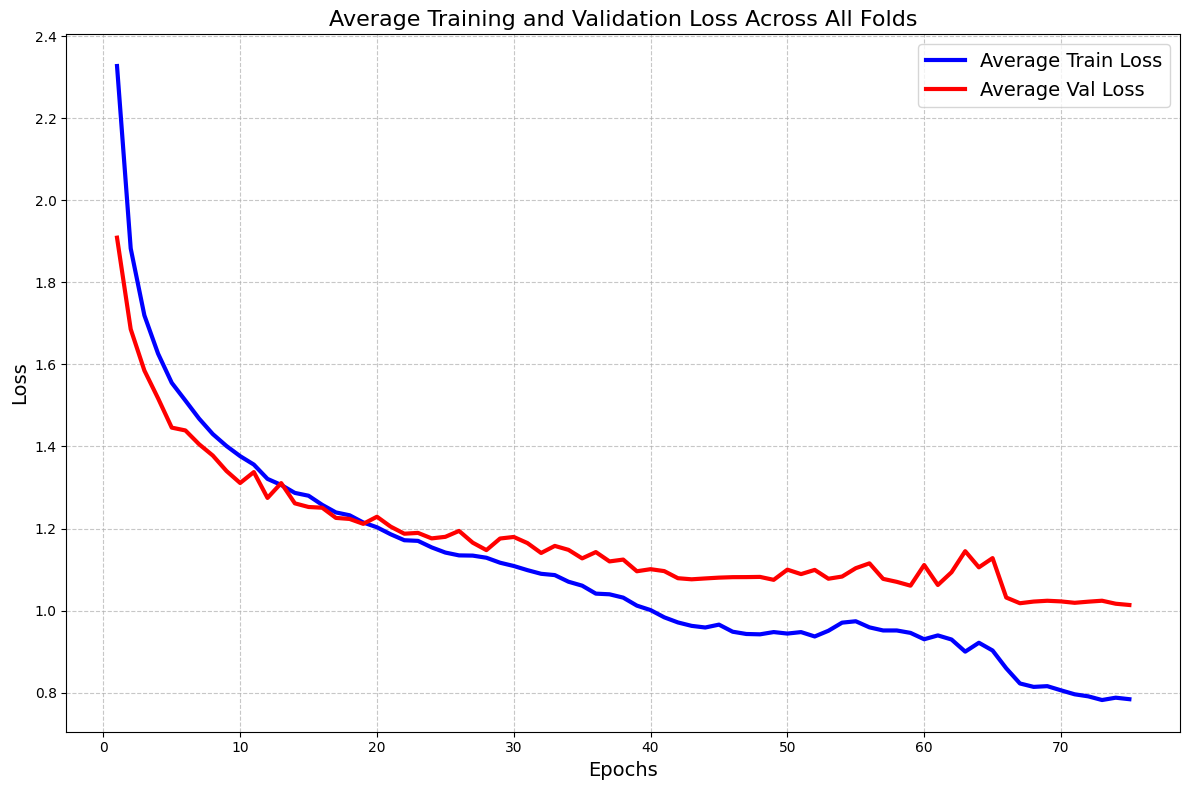

In [26]:
plt.figure(figsize=(12, 8))

# Plot training loss for all folds
for i, fold in enumerate(tof_training_history):
    train_loss = fold['train_loss']
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, '-', linewidth=2, label=f'Fold {i+1} Train Loss')

# Plot validation loss for all folds
for i, fold in enumerate(tof_training_history):
    val_loss = fold['val_loss']
    epochs = range(1, len(val_loss) + 1)
    plt.plot(epochs, val_loss, '--', linewidth=2, label=f'Fold {i+1} Val Loss')

plt.title('Training and Validation Loss Across All Folds', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Calculate and display average loss across folds
max_epochs = max([len(fold['train_loss']) for fold in tof_training_history])
avg_train_loss = np.zeros(max_epochs)
avg_val_loss = np.zeros(max_epochs)
counts_train = np.zeros(max_epochs)
counts_val = np.zeros(max_epochs)

for fold in tof_training_history:
    for i, loss in enumerate(fold['train_loss']):
        avg_train_loss[i] += loss
        counts_train[i] += 1
    for i, loss in enumerate(fold['val_loss']):
        avg_val_loss[i] += loss
        counts_val[i] += 1

# Compute averages
for i in range(max_epochs):
    if counts_train[i] > 0:
        avg_train_loss[i] /= counts_train[i]
    if counts_val[i] > 0:
        avg_val_loss[i] /= counts_val[i]

# Plot average losses
plt.figure(figsize=(12, 8))
plt.plot(range(1, max_epochs + 1), avg_train_loss, 'b-', linewidth=3, label='Average Train Loss')
plt.plot(range(1, max_epochs + 1), avg_val_loss, 'r-', linewidth=3, label='Average Val Loss')
plt.title('Average Training and Validation Loss Across All Folds', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

In [37]:
import util.tof_model, importlib
importlib.reload(util.tof_model)
from util.tof_model import TOF_Model

In [41]:
# with open("data/processed/train_dataset_v1.pkl", "rb") as f:
#     train_dataset = pickle.load(f)

# with open("data/processed/test_dataset_v1.pkl", "rb") as f:
#     test_dataset = pickle.load(f)

with open("results/tof_model_v1_training_history.pkl", "rb") as f:
    tof_training_history = pickle.load(f)

tof_training_history[0]['best_model']

'/home/ziran_unix/projects/Kaggle/CMI/results/weights/tof_model_v1_weights_fold_1.pth'

In [42]:
labels, preds = [], []
for fold in tof_training_history:
    model_weights = fold['best_model'] if not isinstance(fold['best_model'], str) else torch.load(fold['best_model'])
    test_model = TOF_Model(**fold['model_params'])
    test_model.load_state_dict(model_weights)

    pred_idx = fold['val_idx']
    fold_labels, fold_preds = test_model.predict(train_dataset, pred_idx)
    labels.append(fold_labels)
    preds.append(fold_preds)

labels = torch.cat(labels, dim=0)
preds = torch.cat(preds, dim=0)

print(f"low level accuracy: {(labels==preds).float().mean()}")

low level accuracy: 0.5714636445045471


In [43]:
mapping_tensor = torch.tensor([0 if i in good_labels else 1 for i in range(18)])
mapped_labels = mapping_tensor[labels]
mapped_preds = mapping_tensor[preds]

print(f"high level accuracy: {(mapped_labels==mapped_preds).float().mean()}")

high level accuracy: 0.9779168367385864


In [40]:
for i, fold in enumerate(tof_training_history):
    filepath = Path(current_dir) / "results" / "weights" / f"tof_model_v1_weights_fold_{i+1}.pth"
    model_weights = fold['best_model']
    torch.save(model_weights, filepath)
    fold['best_model'] = filepath.as_posix()

with open("results/tof_model_v1_training_history.pkl", "wb") as f:
    pickle.dump(tof_training_history, f)